In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.layers import Input, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D, Dense
from keras.layers import Conv2D, BatchNormalization, Activation, Concatenate
from keras.models import Model
# from keras.datasets import cifar10
from keras import backend
from keras.utils import to_categorical
from keras.callbacks import LearningRateScheduler
from vbranch.datasets.cifar10 import load_data

Using TensorFlow backend.


In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
backend.set_session(session)

## DenseNet

In [4]:
def dense_block(x, blocks, name, growth_rate=32):
    for i in range(blocks):
        x = conv_block(x, growth_rate, name=name+'_block'+str(i+1))
    return x

def transition_block(x, reduction, name):
    x = BatchNormalization(epsilon=1.001e-5, name=name + '_bn')(x)
    x = Activation('relu', name=name + '_relu')(x)
    x = Conv2D(int(backend.int_shape(x)[-1] * reduction), 1, use_bias=False,
            name=name + '_conv')(x)
    x = AveragePooling2D(2, strides=2, name=name + '_pool')(x)
    return x

def conv_block(x, growth_rate, name):
    x1 = BatchNormalization(epsilon=1.001e-5, name=name + '_0_bn')(x)
    x1 = Activation('relu', name=name + '_0_relu')(x1)
    x1 = Conv2D(4 * growth_rate, 1, use_bias=False,
            name=name + '_1_conv')(x1)
    x1 = BatchNormalization(epsilon=1.001e-5, name=name + '_1_bn')(x1)
    x1 = Activation('relu', name=name + '_1_relu')(x1)
    x1 = Conv2D(growth_rate, 3, padding='same', use_bias=False,
               name=name + '_2_conv')(x1)
    x = Concatenate(name=name + '_concat')([x, x1])
    return x

In [5]:
def DenseNet(depth, growth_rate, input_shape, classes=10):
    # No BC -> divide by 3
    # BC -> divide by 6
    n_layers = (depth - 4) // 6

    img_input = Input(shape=input_shape)

    x = ZeroPadding2D(padding=(1, 1))(img_input)
    x = Conv2D(growth_rate*2, 3, use_bias=False, name='conv1/conv')(x)

    x = dense_block(x, n_layers, 'conv2', growth_rate)
    x = transition_block(x, 0.5, 'pool2')
    x = dense_block(x, n_layers, 'conv3', growth_rate)
    x = transition_block(x, 0.5, 'pool3')
    x = dense_block(x, n_layers, 'conv4', growth_rate)

    x = BatchNormalization(epsilon=1.001e-5, name='bn')(x)
    x = Activation('relu', name='relu')(x)
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dense(classes, name='output', activation='softmax')(x)

    return Model(img_input, x)

## Train

In [6]:
(X_train, y_train), (X_test, y_test) = load_data(preprocess=True, one_hot=True)
# y_train = to_categorical(y_train, num_classes=10)
# y_test = to_categorical(y_test, num_classes=10)

In [7]:
def normalize(images):
    demeaned = images.astype('float32') - np.mean(images, axis=(0,1,2))
    normalized = demeaned / np.std(X_train, axis=(0,1,2))
    return normalized

def random_crop(images, labels, padding=2, multiple=3, imsize=32):
    augmented_images = []
    augmented_labels = []
    
    pad_spec = ((0,0), (padding, padding), (padding, padding), (0,0))
    padded_images = np.pad(images, pad_spec, 'constant', constant_values=0)

    for im, lb in zip(padded_images, labels):
        for _ in range(multiple):
            crop_x = np.random.randint(2*padding)
            crop_y = np.random.randint(2*padding)
            cropped_im = im[crop_y:imsize+crop_y, crop_x:imsize+crop_x]
            
            if np.random.random() < 0.5:
                cropped_im = np.flip(cropped_im, axis=1)
                
            augmented_images.append(cropped_im)
            augmented_labels.append(lb)

    return np.array(augmented_images), np.array(augmented_labels)

In [8]:
# # Preprocessing
# X_train_norm = normalize(X_train)
# X_test_norm = normalize(X_test)
# X_train_aug, y_train_aug = random_crop(X_train_norm, y_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


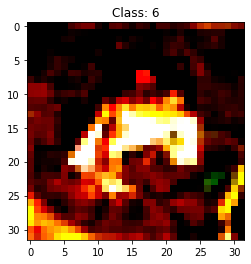

In [9]:
n = 0
plt.imshow(X_train[n])
plt.title(f'Class: {np.argmax(y_train[n])}')
plt.show()

In [10]:
model = DenseNet(depth=100, growth_rate=12, input_shape=(32,32,3))

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 34, 34, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 24)   648         zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv2_block1_0_bn (BatchNormali (None, 32, 32, 24)   96          conv1/conv[0][0]                 
____________________________________________________________________________________________

In [12]:
def step_learning_rate(epoch):
    if epoch < 100:
        return 0.001
    elif epoch < 150:
        return 0.0001
    else:
        return 0.00001

In [13]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [14]:
model.fit(X_train, y_train, 
          epochs=200, batch_size=64, shuffle=True,
          validation_data=(X_test, y_test), 
          callbacks=[LearningRateScheduler(step_learning_rate)])


Train on 50000 samples, validate on 10000 samples
Epoch 1/200
50000/50000 [==============================] - 373s 7ms/step - loss: 1.1966 - accuracy: 0.5668 - val_loss: 1.2046 - val_accuracy: 0.5769
Epoch 2/200
50000/50000 [==============================] - 351s 7ms/step - loss: 0.7837 - accuracy: 0.7247 - val_loss: 2.2098 - val_accuracy: 0.4624
Epoch 3/200
50000/50000 [==============================] - 355s 7ms/step - loss: 0.5978 - accuracy: 0.7919 - val_loss: 0.8675 - val_accuracy: 0.7014
Epoch 4/200
50000/50000 [==============================] - 329s 7ms/step - loss: 0.4862 - accuracy: 0.8318 - val_loss: 0.7847 - val_accuracy: 0.7287
Epoch 5/200
50000/50000 [==============================] - 354s 7ms/step - loss: 0.4137 - accuracy: 0.8580 - val_loss: 0.6403 - val_accuracy: 0.7926
Epoch 6/200
50000/50000 [==============================] - 353s 7ms/step - loss: 0.3465 - accuracy: 0.8801 - val_loss: 0.5756 - val_accuracy: 0.8122
Epoch 7/200
50000/50000 [==============================

Epoch 54/200
50000/50000 [==============================] - 273s 5ms/step - loss: 0.0237 - accuracy: 0.9920 - val_loss: 0.8876 - val_accuracy: 0.8524
Epoch 55/200
50000/50000 [==============================] - 273s 5ms/step - loss: 0.0221 - accuracy: 0.9920 - val_loss: 0.7972 - val_accuracy: 0.8512
Epoch 56/200
50000/50000 [==============================] - 271s 5ms/step - loss: 0.0186 - accuracy: 0.9938 - val_loss: 0.8244 - val_accuracy: 0.8538
Epoch 57/200
50000/50000 [==============================] - 266s 5ms/step - loss: 0.0190 - accuracy: 0.9937 - val_loss: 0.8208 - val_accuracy: 0.8557
Epoch 58/200
50000/50000 [==============================] - 271s 5ms/step - loss: 0.0244 - accuracy: 0.9915 - val_loss: 0.6525 - val_accuracy: 0.8731
Epoch 59/200
50000/50000 [==============================] - 267s 5ms/step - loss: 0.0201 - accuracy: 0.9928 - val_loss: 0.6480 - val_accuracy: 0.8773
Epoch 60/200
50000/50000 [==============================] - 271s 5ms/step - loss: 0.0217 - accuracy:

50000/50000 [==============================] - 268s 5ms/step - loss: 2.4083e-04 - accuracy: 1.0000 - val_loss: 0.5856 - val_accuracy: 0.8975
Epoch 109/200
50000/50000 [==============================] - 272s 5ms/step - loss: 1.7459e-04 - accuracy: 1.0000 - val_loss: 0.5877 - val_accuracy: 0.8977
Epoch 110/200
50000/50000 [==============================] - 272s 5ms/step - loss: 2.2649e-04 - accuracy: 1.0000 - val_loss: 0.6072 - val_accuracy: 0.8963
Epoch 111/200
50000/50000 [==============================] - 268s 5ms/step - loss: 1.8188e-04 - accuracy: 1.0000 - val_loss: 0.5998 - val_accuracy: 0.8986
Epoch 112/200
50000/50000 [==============================] - 272s 5ms/step - loss: 1.8008e-04 - accuracy: 1.0000 - val_loss: 0.5959 - val_accuracy: 0.8980
Epoch 113/200
50000/50000 [==============================] - 268s 5ms/step - loss: 2.1374e-04 - accuracy: 1.0000 - val_loss: 0.6081 - val_accuracy: 0.8957
Epoch 114/200
50000/50000 [==============================] - 272s 5ms/step - loss: 1

Epoch 161/200
50000/50000 [==============================] - 127s 3ms/step - loss: 1.8081e-05 - accuracy: 1.0000 - val_loss: 0.6926 - val_accuracy: 0.8973
Epoch 162/200
50000/50000 [==============================] - 127s 3ms/step - loss: 1.8377e-05 - accuracy: 1.0000 - val_loss: 0.6929 - val_accuracy: 0.8976
Epoch 163/200
50000/50000 [==============================] - 127s 3ms/step - loss: 3.3423e-05 - accuracy: 1.0000 - val_loss: 0.6899 - val_accuracy: 0.8973
Epoch 164/200
50000/50000 [==============================] - 127s 3ms/step - loss: 1.8677e-05 - accuracy: 1.0000 - val_loss: 0.6907 - val_accuracy: 0.8976
Epoch 165/200
50000/50000 [==============================] - 127s 3ms/step - loss: 2.8704e-05 - accuracy: 1.0000 - val_loss: 0.6887 - val_accuracy: 0.8978
Epoch 166/200
50000/50000 [==============================] - 127s 3ms/step - loss: 2.2249e-05 - accuracy: 1.0000 - val_loss: 0.6894 - val_accuracy: 0.8980
Epoch 167/200
50000/50000 [==============================] - 127s 3ms/

In [ ]:
# model.save('densenet-cifar10+-adam.h5')